# FlagIRLS Examples

These are the examples for the FlagIRLS chapter.

In [1]:
import numpy as np
import sys
sys.path.append('./scripts/')
import center_algorithms as ca
import matplotlib.pyplot as plt
import torch
import pandas
import seaborn as sns
from sklearn.manifold import MDS
import time

In [2]:
'''
This function verifies that we found a local optimizer for
the sine median or maximum cosine problem.
It does this by checking 100 points around the optimizer.

Inputs: 
    optimizer- a numpy array that represente the suggested optimizer
    opf_fn- a string, 'sine' for sine median and 'cosine' for maximum cosine
    data- a list of numpy arrays representing points on grassmannians
Outputs:
    local optimizer- True if all checked points rsesult in objective function values
                        that are greater than the Sine Median problem or smaller than
                        the Maximum Cosine value
'''
def sanity_check(optimizer, opt_fn, data):
    
    n,r = optimizer.shape
    
    
    #objective function value for suggested optimizer
    sln_val = ca.calc_error_1_2(data, optimizer, opt_fn) 
    
    #stays true if optimizer is a local min
    local_optimizer = True

    #checking random points
    perturb_vals = []
    for i in range(100):
        
        #random points between -.5 and .5 times .00001
        perturb = (np.random.rand(n,r)-5)*.00001 
        perturb_check = np.linalg.qr(perturb + optimizer)[0][:,:r]
        
        #check objective function value
        perturb_vals.append(ca.calc_error_1_2(data, perturb_check, opt_fn))

        if opt_fn == 'sine' or opt_fn == 'l2_med':
            if perturb_vals[i] < sln_val:
                local_optimizer = False
        elif opt_fn == 'cosine':
            if perturb_vals[i] > sln_val:
                local_optimizer = False
        

    # if not local_optimizer:
    #     print('Algorithm did not converge to maximizer')
    return local_optimizer

def calc_chordal_dist(X, Y, r):
    sum_sin = r- np.trace(X.T @ Y @ Y.T @ X)
    if sum_sin < 0:
        sum_sin = 0
    return np.sqrt(sum_sin)

def calc_cos_sim(X, Y, r):
    sum_cos = np.trace(X.T @ Y @ Y.T @ X)
    if sum_cos < 0:
        sum_cos = 0
    return np.sqrt(sum_cos)

    

## Convergence Example

In [3]:
k1=3 #Gr(k1,n)
k2=5 #Gr(k2,n)
r=3
n=20
n_its = 100 #number of iterations for FlagIRLS
seed = 1 #random seed
num_points = 20 #number of points in dataset
n_trials = 100 #number of trials for sanity check

#generate dataset of points in Gr(ki,n)
#half the points are in Gr(k1,n) and the second half are in Gr(k2,n)

np.random.seed(0)

gr_list = []
for i in range(1 + num_points//2):
    Y_raw = np.random.rand(n,k1)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k1]
    gr_list.append(Y)
for i in range(num_points//2):
    Y_raw = np.random.rand(n,k2)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k2]
    gr_list.append(Y)


### Verify Convergence for Flag Median

In [4]:
n_corrects = 0

for seed in range(1,n_trials+1):
    flag_median = ca.irls_flag(gr_list, r, n_its, 'sine', opt_err = 'sine', seed = seed)[0]
    
    
    if sanity_check(flag_median, 'sine', gr_list):
        n_corrects += 1        


print(str(100* (n_corrects/n_trials))+' percent of trials that resulted in local optimizers')

100.0 percent of trials that resulted in local optimizers


### Verify Convergence for Maximally Correlated Subspace

In [5]:
n_corrects = 0

for seed in range(1,n_trials+1):
    thing, err = ca.irls_flag(gr_list, r, n_its, 'cosine', opt_err = 'cosine', seed = seed)
    
    
    if sanity_check(thing, 'cosine', gr_list):
        n_corrects += 1        


print(str(100* (n_corrects/n_trials))+' percent of trials that resulted in local optimizers')

68.0 percent of trials that resulted in local optimizers


### Verify Convergence for $\ell_2$-median

In [6]:
n_corrects = 0
new_r = 1

for seed in range(1,n_trials+1):
    thing, err = ca.irls_flag(gr_list, new_r, n_its, 'geodesic', opt_err = 'geodesic', seed = seed)
    
    
    if sanity_check(thing, 'geodesic', gr_list):
        n_corrects += 1        


print(str(100* (n_corrects/n_trials))+' percent of trials that resulted in local optimizers')

/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100.0 percent of trials that resulted in local optimizers


## Comparison to Gradient Descent

In [24]:
k1=3 #Gr(k1,n)
r=3
n=20
n_its = 100 #number of iterations for FlagIRLS
seed = 1 #random seed
num_points = 20 #number of points in dataset
n_trials = 100 #number of trials for sanity check

#generate dataset of points in Gr(ki,n)
#half the points are in Gr(k1,n) and the second half are in Gr(k2,n)

np.random.seed(0)

gr_list = []
for i in range(num_points):
    Y_raw = np.random.rand(n,k1)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k1]
    gr_list.append(Y)
# for i in range(num_points//2):
#     Y_raw = np.random.rand(n,k2)-.5
#     Y = np.linalg.qr(Y_raw)[0][:,:k2]
#     gr_list.append(Y)


Text(0, 0.5, 'Objective Function Value')

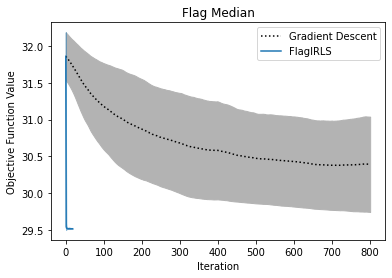

In [25]:
n_its = 800

flg_errs = []
gd_errs = []
for seed in range(100):
    flg_errs.append(np.array(ca.irls_flag(gr_list, r, n_its, 'sine', opt_err = 'sine', seed = seed, diff_eps = .00001)[1]))
    gd_errs.append(np.array(ca.gradient_descent(gr_list, r, -.01, n_its, 'sine', seed = seed)[1]))

flg_err = []
flg_stds = []
for i in range(np.max([len(fe) for fe in flg_errs])):
    fes = []
    for fe in flg_errs:
        if len(fe) > i:
            fes.append(fe[i])
    flg_err.append(np.mean(fes))
    flg_stds.append(np.std(fes))
flg_err = np.array(flg_err)
flg_stds = np.array(flg_stds)


gd_err = np.mean(np.vstack(gd_errs), axis = 0)
gd_stds = np.std(np.vstack(gd_errs), axis = 0)

plt.figure()
plt.fill_between(np.arange(len(gd_stds)), gd_err-gd_stds, gd_err+gd_stds, color = '0.7')
plt.plot(gd_err, label = 'Gradient Descent', color = 'black', linestyle = 'dotted')
plt.fill_between(np.arange(len(flg_stds)), flg_err-flg_stds, flg_err+flg_stds, color = 'tab:blue', alpha = .5)
plt.plot(flg_err, label = 'FlagIRLS', color = 'tab:blue', linestyle = 'solid')
plt.title('Flag Median')
plt.legend()
# plt.xticks([n for n in range(0,21,5)])
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

In [8]:
# n_its = 800

# flg_errs = []
# gd_errs = []
# for seed in range(100):
#     flg_errs.append(np.array(ca.irls_flag(gr_list, r, n_its, 'cosine', opt_err = 'cosine', seed = seed)[1]))
#     gd_errs.append(np.array(ca.gradient_descent(gr_list, r, -.01, n_its, 'cosine', seed = seed)[1]))

# flg_err = []
# flg_stds = []
# for i in range(np.max([len(fe) for fe in flg_errs])):
#     fes = []
#     for fe in flg_errs:
#         if len(fe) > i:
#             fes.append(fe[i])
#     flg_err.append(np.mean(fes))
#     flg_stds.append(np.std(fes))
# flg_err = np.array(flg_err)
# flg_stds = np.array(flg_stds)


# gd_err = np.mean(np.vstack(gd_errs), axis = 0)
# gd_stds = np.std(np.vstack(gd_errs), axis = 0)

# plt.figure()
# plt.fill_between(np.arange(len(gd_stds)), gd_err-gd_stds, gd_err+gd_stds, color = '0.7')
# plt.plot(gd_err, label = 'Gradient Descent', color = 'black', linestyle = 'dotted')
# plt.fill_between(np.arange(len(flg_stds)), flg_err-flg_stds, flg_err+flg_stds, color = 'red', alpha = .5)
# plt.plot(flg_err, label = 'FlagIRLS', color = 'red', linestyle = 'solid')
# plt.title('Maximally Correlated Flag')
# plt.legend()
# # plt.xticks([n for n in range(0,21,5)])
# plt.xlabel('Iteration')
# plt.ylabel('Objective Function Value')

## Comparison to Weiszfeld-type Algorithm

In [21]:
k1=1 #Gr(k1,n)
r=1
n=20
n_its = 100 #number of iterations for FlagIRLS
seed = 1 #random seed
num_points = 20 #number of points in dataset
n_trials = 100 #number of trials for sanity check

#generate dataset of points in Gr(ki,n)
#half the points are in Gr(k1,n) and the second half are in Gr(k2,n)

np.random.seed(3)
center = np.random.rand(n,k1)-.5

gr_list = []
for i in range(num_points):
    Y_raw = np.random.rand(n,k1)-.5
    Y = np.linalg.qr(center + Y_raw*.1)[0][:,:k1]
    gr_list.append(Y)
# for i in range(num_points//2):
#     Y_raw = np.random.rand(n,k2)-.5
#     Y = np.linalg.qr(Y_raw)[0][:,:k2]
#     gr_list.append(Y)


/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0, 0.5, 'Objective Function Value')

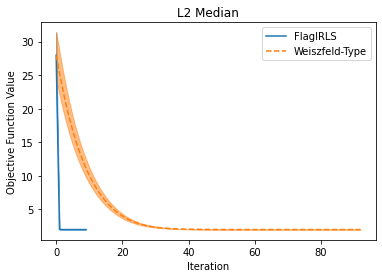

In [23]:
n_its = 300

flg_errs = []
gd_errs = []
wt_errs = []
for seed in range(100):
    flg_errs.append(np.array(ca.irls_flag(gr_list, r, n_its, 'geodesic', opt_err = 'geodesic', seed = seed)[1]))
    # gd_errs.append(np.array(ca.gradient_descent(gr_list, r, -.01, n_its, 'geodesic', seed = seed)[1]))
    wt_errs.append(np.array(ca.l2_median(gr_list, .1, r, 1000, seed)[1]))

flg_err = []
flg_stds = []
for i in range(np.max([len(fe) for fe in flg_errs])):
    fes = []
    for fe in flg_errs:
        if len(fe) > i:
            fes.append(fe[i])
    flg_err.append(np.mean(fes))
    flg_stds.append(np.std(fes))
flg_err = np.array(flg_err)
flg_stds = np.array(flg_stds)


# gd_err = np.mean(np.vstack(gd_errs), axis = 0)
# gd_stds = np.std(np.vstack(gd_errs), axis = 0)

wt_err = []
wt_stds = []
for i in range(np.max([len(fe) for fe in wt_errs])):
    fes = []
    for fe in wt_errs:
        if len(fe) > i:
            fes.append(fe[i])
    wt_err.append(np.mean(fes))
    wt_stds.append(np.std(fes))
wt_err = np.array(wt_err)
wt_stds = np.array(wt_stds)

plt.figure()
# plt.fill_between(np.arange(len(gd_stds)), gd_err-gd_stds, gd_err+gd_stds, color = '0.7')
# plt.plot(gd_err, label = 'Gradient Descent', color = 'black', linestyle = 'dotted')
plt.fill_between(np.arange(len(flg_stds)), flg_err-flg_stds, flg_err+flg_stds, color = 'tab:blue', alpha = .5)
plt.plot(flg_err, label = 'FlagIRLS', color = 'tab:blue', linestyle = 'solid')
plt.fill_between(np.arange(len(wt_stds)), wt_err-wt_stds, wt_err+wt_stds, color = 'tab:orange', alpha = .5)
plt.plot(wt_err, label = 'Weiszfeld-Type', color = 'tab:orange', linestyle = 'dashed')
plt.title('L2 Median')
plt.legend()
# plt.xticks([n for n in range(0,21,5)])
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

## Stochastic FlagIRLS

In [2]:

num_points = 100


n_its = 500


n = 1000
r = 20
k = 20

n_trials = 20

In [3]:
center = np.random.rand(n,k)*10
center_rep = np.linalg.qr(center)[0][:,:k]

#generate dataset of points in Gr(k,n)
data = []
for i in range(num_points):
    Y_raw = center_rep + (np.random.rand(n,k)-.5)*.01
    Y = np.linalg.qr(Y_raw)[0][:,:k]
    data.append(Y)

np.random.seed(1)
Y_init = np.linalg.qr(np.random.rand(n,n))[0][:,:k]



In [ ]:
vanilla_run_times = []
vanilla_function_values = []
for i in range(n_trials):

    start = time.time()
    vanilla_sln, vanilla_error = ca.irls_flag(data, k, n_its, 'sine', opt_err = 'sine', init = Y_init)

    vanilla_run_times.append(time.time()- start)



    vanilla_function_values.append(ca.calc_error_1_2(data, vanilla_sln, 'sine'))


print('total time '+str(np.mean(vanilla_run_times))+' +/- '+str(np.std(vanilla_run_times)))

print('number or iterations ' +str(len(vanilla_error)))

print('objective function value :'+str(np.mean(vanilla_function_values))+' +/- '+str(np.std(vanilla_function_values)))

./scripts/center_algorithms.py:369: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init == 'random':
./scripts/center_algorithms.py:374: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif init == 'data':


total time 5.2146814346313475 +/- 0.24321804923577703
number or iterations 4
objective function value :40.061728194736965 +/- 7.105427357601002e-15


In [13]:
objective_function_value_means = []
objective_function_value_stds = []
stochastic_run_times_means = []
stochastic_run_times_stds = []

xs = [i for i in range(5, num_points,5)]
for num_stochastic_pts in xs:

    total_times = []
    fn_vals = []
    for i in range(n_trials):
        start = time.time()

        stochastic_sln, stochastic_errors = ca.irls_flag(data, k, n_its, 'sine', opt_err = 'sine', init = Y_init, stochastic = num_stochastic_pts)

        total_times.append(time.time()- start)
        fn_vals.append(ca.calc_error_1_2(data, stochastic_sln, 'sine'))


    stochastic_run_times_means.append(np.mean(total_times))
    stochastic_run_times_stds.append(np.std(total_times))
    print('total time '+str(stochastic_run_times_means[-1])+ ' +/- ' +str(stochastic_run_times_stds[-1]))

    print('number or iterations ' +str(len(stochastic_errors)))

    objective_function_value_means.append(np.mean(fn_vals))
    objective_function_value_stds.append(np.std(fn_vals))
    print('objective function value :'+str(objective_function_value_means[-1])+ ' +/- ' +str(objective_function_value_stds[-1]))

total time 0.18842642307281493 +/- 0.052256462457096156
number or iterations 3
objective function value :43.690897973774106 +/- 0.02194549642006905
total time 0.30898892879486084 +/- 0.08231213155921237
number or iterations 2
objective function value :41.81938391082292 +/- 0.011967011311601841
total time 0.44046318531036377 +/- 0.15681095749344365
number or iterations 3
objective function value :41.229167359383936 +/- 0.078529430092008
total time 0.6205408215522766 +/- 0.1403606264226326
number or iterations 2
objective function value :40.930910639685074 +/- 0.09991935224033677
total time 0.7749021530151368 +/- 0.21723902910498205
number or iterations 2
objective function value :40.81333394240088 +/- 0.0705869049685512
total time 0.9788903713226318 +/- 0.279369683559401
number or iterations 4
objective function value :40.661122300863994 +/- 0.06256265088337619
total time 1.1738288879394532 +/- 0.5134773398602998
number or iterations 2
objective function value :40.57252865500794 +/- 0.0

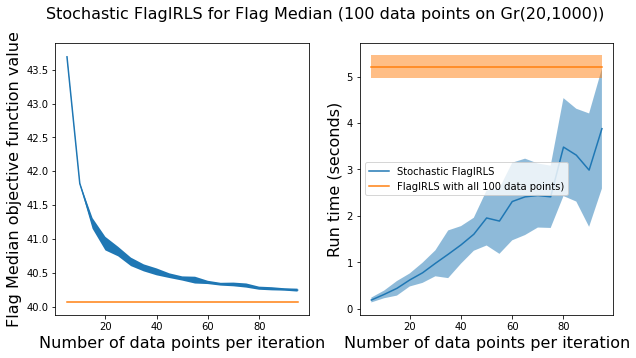

In [14]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

fig.suptitle('Stochastic FlagIRLS for Flag Median (100 data points on Gr(20,1000))', size = 16)

ax[0].plot(xs, objective_function_value_means, label = 'Stochastic FlagIRLS')
ax[0].fill_between(xs, np.array(objective_function_value_means)-np.array(objective_function_value_stds), np.array(objective_function_value_means)+np.array(objective_function_value_stds))
ax[0].plot(xs, [np.mean(vanilla_function_values)]*len(objective_function_value_means), label = 'vanilla FlagIRLS (all 100 data points)')
# plt.fill_between(xs, [np.mean(vanilla_function_values)- np.std(vanilla_function_values)]*len(objective_function_value_means), [np.mean(vanilla_function_values)+ np.std(vanilla_function_values)]*len(objective_function_value_means))
ax[0].set_xlabel('Number of data points per iteration', size = 16)
ax[0].set_ylabel('Flag Median objective function value', size = 16)

ax[1].plot(xs, stochastic_run_times_means, label = 'Stochastic FlagIRLS')
ax[1].fill_between(xs, np.array(stochastic_run_times_means)-np.array(stochastic_run_times_stds), np.array(stochastic_run_times_means)+np.array(stochastic_run_times_stds), alpha = .5)
ax[1].plot(xs, [np.mean(vanilla_run_times)]*len(stochastic_run_times_means), label = 'FlagIRLS with all 100 data points)')
ax[1].fill_between(xs, np.array([np.mean(vanilla_run_times)]*len(stochastic_run_times_means))-np.array([np.std(vanilla_run_times)]*len(stochastic_run_times_means)), np.array([np.mean(vanilla_run_times)]*len(stochastic_run_times_means))+np.array([np.std(vanilla_run_times)]*len(stochastic_run_times_means)), alpha = .5)
ax[1].set_xlabel('Number of data points per iteration', size = 16)
ax[1].set_ylabel('Run time (seconds)', size = 16)
plt.legend()

plt.savefig('./results/stochastic_flag_median.png')

## FlagIRLS vs Weiszfeld

In [3]:
k=6 #Gr(k1,n)
r=6
n=100
n_its = 1000 #number of iterationss
n_trials = 20


num_points = 200 #number of points in dataset
n_trials = 20 #number of trials for sanity check

len_flag_med_errs = []
len_max_corr_errs = []
len_l2_errs_data = [] 
len_l2_errs_rand = []


flag_med_time = []
max_corr_time = []
l2_errs_data_time = []
l2_errs_rand_time = []
for seed in range(n_trials):

    np.random.seed(seed)

    center = np.random.rand(n,k)*10
    center_rep = np.linalg.qr(center)[0][:,:k]

    diameter = 10**(-2)
    #generate dataset of points in Gr(k,n)
    gr_list = []
    for i in range(num_points):
        Y_raw = center_rep + (np.random.rand(n,k)-.5)*diameter
        Y = np.linalg.qr(Y_raw)[0][:,:k]
        gr_list.append(Y)


    #calculate sine median
    start = time.time()
    sine_median_error = ca.irls_flag(gr_list, r, n_its-1, 'sine', opt_err = 'sine', seed = seed)[1]
    flag_med_time.append(time.time()-start)
    len_flag_med_errs.append(len(sine_median_error))

    # #calc maximally correlated flag
    # start = time.time()
    # max_corr_error = ca.irls_flag(gr_list, r, n_its-1, 'cosine', opt_err = 'cosine', seed = seed)[1]
    # max_corr_time.append(time.time()-start)
    # len_max_corr_errs.append(len(max_corr_error))

    #calc l2 median datapoint initialization
    start = time.time()
    l2_errs_data = ca.l2_median(gr_list, .1, r, n_its, seed, True)[1]
    l2_errs_data_time.append(time.time()-start)
    len_l2_errs_data.append(len(l2_errs_data))

    #calc l2 median random initialization
    start = time.time()
    l2_errs_rand = ca.l2_median(gr_list, .1, r, n_its, seed, False)[1]
    l2_errs_rand_time.append(time.time()-start)
    len_l2_errs_rand.append(len(l2_errs_rand))
  

print('average number of its to converge')
print('flag median: '+str(np.mean(len_flag_med_errs))+' +/-'+str(np.std(len_flag_med_errs)))
# print('maximally correlated flag: '+str(np.mean(len_max_corr_errs))+' +/-'+str(np.std(len_max_corr_errs)))
print('l2 median: (init datapoint) '+str(np.mean(len_l2_errs_data))+' +/-'+str(np.std(len_l2_errs_data)))
print('l2 median: (init same as flag median) '+str(np.mean(len_l2_errs_rand))+' +/-'+str(np.std(len_l2_errs_rand)))

          
print('average times to convergence')   
print('flag median: '+str(np.mean(flag_med_time))+' +/-'+str(np.std(flag_med_time)))
# print('maximally correlated flag: '+str(np.mean(max_corr_time))+' +/-'+str(np.std(max_corr_time)))
print('l2 median: (init datapoint) '+str(np.mean(l2_errs_data_time))+' +/-'+str(np.std(l2_errs_data_time)))
print('l2 median: (init same as flag median) '+str(np.mean(l2_errs_rand_time))+' +/-'+str(np.std(l2_errs_rand_time)))

./scripts/center_algorithms.py:74: RuntimeWarning: invalid value encountered in arccos
  angles = np.real(np.arccos(S))


average number of its to converge
flag median: 4.45 +/-0.4974937185533101
l2 median: (init datapoint) 151.7 +/-356.35727858428817
l2 median: (init same as flag median) 757.0 +/-283.05246863435053
average times to convergence
flag median: 0.4307423114776611 +/-0.09367833705904925
l2 median: (init datapoint) 4.436809837818146 +/-10.291102523762442
l2 median: (init same as flag median) 21.271026599407197 +/-7.887624044149113


## Cluster with Outliers

/tmp/ipykernel_93688/252303475.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(num_points- np.int(num_points*.10)):
/tmp/ipykernel_93688/252303475.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

Flag Mean finished
Flag Median finished
L2 median finished
flag median converged correctly
flag mean chordal dist is: 0.012849444601543
flag median chordal dist is: 0.0017154974679212073
l2 median chordal dist is: 0.0021799699970289654
---------------------
flag mean cosine similarity is: 1.7320031442735409
flag median cosine similarity is: 1.732049958017504
l2 median cosine similarity is: 1.7320494357063865


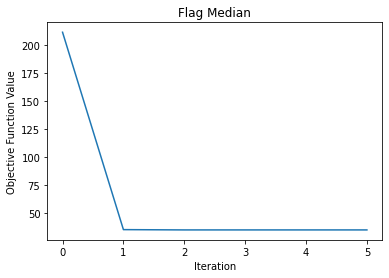

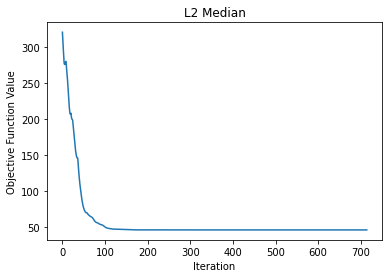

In [3]:
k=3 #Gr(k1,n)
r=3
n=20
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #random seed
num_points = 200 #number of points in dataset
n_trials = 100 #number of trials for sanity check

np.random.seed(seed)

center = np.random.rand(n,k)*10
center_rep = np.linalg.qr(center)[0][:,:k]

#generate dataset of points in Gr(k,n)
gr_list = []
for i in range(num_points- np.int(num_points*.10)):
    Y_raw = center_rep + (np.random.rand(n,k)-.5)*.01
    Y = np.linalg.qr(Y_raw)[0][:,:k]
    gr_list.append(Y)
    
for i in range(np.int(num_points*.10)):
    Y_raw = np.random.rand(n,k)-.5
    Y = np.linalg.qr(Y_raw)[0][:,:k]
    gr_list.append(Y)
    

#calculate flag mean
flag_mean = ca.flag_mean(gr_list, r)
print('Flag Mean finished')

#calculate flag median
flg_median, flg_err = ca.irls_flag(gr_list, r, n_its, 'sine', opt_err = 'sine', seed = seed)
print('Flag Median finished')

# #calculate maximally correlated flag
# cor_median, cor_err = ca.irls_flag(gr_list, r, n_its, 'cosine', opt_err = 'cosine', seed = seed)
# print('Maximally Correlated Flag finished')

#calculate l2 median
l2_med, l2_err = ca.l2_median(gr_list, .1, r, 1000, seed)
print('L2 median finished')
    
if sanity_check(flg_median, 'sine', gr_list):
    print('flag median converged correctly')  
# if sanity_check(cor_median, 'cosine', gr_list):
#     print('maximally correlated flag converged correctly')       
if sanity_check(l2_med, 'l2_med', gr_list):
    print('l2 median converged correctly') 
    
plt.figure()
plt.plot(flg_err)
plt.title('Flag Median')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

# plt.figure()
# plt.plot(cor_err)
# plt.title('Maximally Correlated Flag')
# plt.xlabel('Iteration')
# plt.ylabel('Objective Function Value')


plt.figure()
plt.plot(l2_err)
plt.title('L2 Median')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

    
print('flag mean chordal dist is: ' +str(calc_chordal_dist(center_rep, flag_mean, r)))

print('flag median chordal dist is: ' +str(calc_chordal_dist(center_rep, flg_median, r)))

# print('maximally correlated flag chordal dist is: ' +str(calc_chordal_dist(center_rep, cor_median, r)))

print('l2 median chordal dist is: ' +str(calc_chordal_dist(center_rep, l2_med, r)))

print('---------------------')

print('flag mean cosine similarity is: ' +str(calc_cos_sim(center_rep, flag_mean, r)))

print('flag median cosine similarity is: ' +str(calc_cos_sim(center_rep, flg_median, r)))

# print('maximally correlated flag cosine similarity is: ' +str(calc_cos_sim(center_rep, cor_median, r)))

print('l2 median cosine similarity is: ' +str(calc_cos_sim(center_rep, l2_med, r)))



## MNIST Examples

In [3]:


def load_mnist_data(digits, sample_size=100, dset='train', shuffle = False, data_path = './data/MNIST/'):
    '''
    Shannon Stiverson's dataloader

    Inputs:
        digits- list or int for digits from MNIST to be samples
        sample_size - number of samples of that digit
        dset - 'train' or 'test' for sampling from the training or the test datasets
    Outputs:
        out_datamat - a numpy array of dimensions (784 x sample_size)
        datamat_labels - a list of labels of the sampled points
    '''

    if type(digits) == int:
        digits = [digits]

    if type(sample_size) == int:
        sample_size = [sample_size]*len(digits)

    if len(sample_size) != len(digits):
        print('Incorrect number of sample sizes given.')
        return [], []

    return_data = []
    return_labels = []

    for i in range(len(digits)):
        digit = digits[i]
        size = sample_size[i]
        digit_data = np.loadtxt(data_path+'%s%i.csv' % (dset, digit), delimiter=',')
        if digit_data.shape[1] < size:
            print('Sample number for digit %i reduced to %i' % (digit, digit_data.shape[1]))
            return_data.append(digit_data)
            return_labels.append([digit]*digit_data.shape[1])
        else:
            if shuffle:
                idx = np.random.choice(np.arange(digit_data.shape[1]), size)
            else:
                idx = np.arange(size)
            return_data.append(digit_data[idx, :])
            return_labels.append([digit]*size)

    datamat = return_data[0]
    datamat_labels = return_labels[0]

    if len(digits) > 1:
        for i in range(1, len(digits)):
            datamat = np.vstack((datamat, return_data[i]))
            datamat_labels = np.hstack((datamat_labels, return_labels[i]))

    out_datamat = datamat.T
    
    return out_datamat, datamat_labels

'''
This function verifies that we found a local optimizer for
the sine median or maximum cosine problem.
It does this by checking 100 points around the optimizer.

Inputs: 
    optimizer- a numpy array that represente the suggested optimizer
    opf_fn- a string, 'sine' for sine median and 'cosine' for maximum cosine
    data- a list of numpy arrays representing points on grassmannians
Outputs:
    local optimizer- True if all checked points rsesult in objective function values
                        that are greater than the Sine Median problem or smaller than
                        the Maximum Cosine value
'''
def mnist_sanity_check(optimizer, opt_fn, data):
    
    n,r = optimizer.shape
    
    
    #objective function value for suggested optimizer
    sln_val = ca.calc_error_1_2(data, optimizer, opt_fn) 
    
    #stays true if optimizer is a local min
    local_optimizer = True

    #checking random points
    perturb_vals = []
    for i in range(100):
        
        #random points between -.5 and .5 times .01
        perturb = (np.random.rand(n,r)-5)*.00001 
        perturb_check = np.linalg.qr(perturb + optimizer)[0][:,:r]
        
        #check objective function value
        perturb_vals.append(ca.calc_error_1_2(data, perturb_check, opt_fn))

        if opt_fn == 'sine' or opt_fn == 'l2_med':
            if perturb_vals[i] < sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to minimizer')
        elif opt_fn == 'cosine':
            if perturb_vals[i] > sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to maximizer')

    # if not local_optimizer:
    #     print(sln_val)
    #     print(perturb_vals)
    return local_optimizer


def run_mnist_test(k, digit1, digit2, num_samples1, num_samples2,n_its,seed):
    '''
    calculates Flag Mean, Maximum Cosine and Sine Median for a dataset

    Inputs:
        k- int for Gr(k,784)
        digit1- int for first digit
        digit2- int for second digit
        num_samples1- int for number of samples of digit1s
        num_samples2- int for number of samples of digit2s
        n_its- integer for the number of iterations of FlagIRLS
        seed- int for numpy random initialization
    Outputs:
        flagmean- numpy array that represents Flag Mean of gr_list
        sin_median- numpy array that represents Sine Median of gr_list
        max_cosine- numpy array that represents Max Cosine of gr_list
        gr_list- dataset as subspaces in Gr(k,748)
    '''
    
    data_matrix1 = load_mnist_data(digit1, k*num_samples1, dset='train')[0]
    data_matrix2 = load_mnist_data(digit2, k*num_samples2, dset='train')[0]

    gr_list = []
    for i in range(num_samples1):
        if k==1:
            point = data_matrix1[:,i*k:(i+1)*k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix1[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])

    for i in range(num_samples2):
        if k==1:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])
            
    
    flg_mean = ca.flag_mean(gr_list, k)
    # print('Flag Mean finished')

    #calculate flag median
    flg_median = ca.irls_flag(gr_list, k, n_its, 'sine', opt_err = 'sine', seed = seed)[0]

    #calculate 
    # max_cor_flg = ca.irls_flag(gr_list, k, n_its, 'cosine', opt_err = 'cosine', seed = seed)[0]

    
    #calculate l2 median
    #do it more than once if needed
    worked = False
    l2_seed = seed
    while not worked:
        l2_med = ca.l2_median(gr_list, .1, k, 1000, l2_seed)[0]
        worked = mnist_sanity_check(l2_med, 'l2_med', gr_list)
        # print('l2 trial')
        l2_seed+=1
        
    # print('L2 median finished')
    
    # return flg_mean, flg_median, max_cor_flg, l2_med, gr_list
    return flg_mean, flg_median, l2_med, gr_list



## MNIST Nerual Network

In [4]:
k = 1 #Gr(k,n)
digit1 = 1
digit2 = 9
num_samples1 = 20 #number of samples of the 2 digit
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 1 #samples 5s from 0 to num_samples2 in increments of incr

plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS

model_path = './models/'

In [5]:
model = torch.load(model_path+'model49.pth')

model.eval()

predictions = pandas.DataFrame(columns = ['Prototype', 'Added Nines', 'Prediction'])

if num_samples1 % incr != 0:
    print('incr does not divide num_samples2 evenly!')
else:
    flag_means = []
    flag_medians = []
    max_cor_flgs = []
    l2_meds = []
    n2s  = []
    n5s = []

    for num_samples2 in range(0,num_samples1,incr):
        out = run_mnist_test(k,digit1,digit2,num_samples1,num_samples2,n_its,seed)
        flag_means.append(out[0])
        flag_medians.append(out[1])
        l2_meds.append(out[2])
        # max_cor_flgs.append(out[2])
        # l2_meds.append(out[3])
        n2s.append(num_samples1)
        n5s.append(num_samples2)
        # dataset = out[4]
        dataset = out[3]
        
    # model = torch.load('../MNIST_Classifier/raw_triangle_nn_3layer_lr_p1/model/model49.pth')
    

    for i in range(20):
        point = flag_medians[i]
        s_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()

        point = flag_means[i]
        f_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()

        # point = max_cor_flgs[i]
        # c_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
        
        point = l2_meds[i]
        l_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
        
        predictions = predictions.append({'Prototype': 'Flag Median',
                                        'Added Nines': i,
                                        'Prediction': s_prediction}, ignore_index = True)

        # predictions = predictions.append({'Prototype': 'Maximally Correlated Flag',
        #                                 'Added Nines': i,
        #                                 'Prediction': c_prediction}, ignore_index = True)

        predictions = predictions.append({'Prototype': 'L2 Median',
                                        'Added Nines': i,
                                        'Prediction': l_prediction}, ignore_index = True)
        
        predictions = predictions.append({'Prototype': 'Flag Mean',
                                        'Added Nines': i,
                                        'Prediction': f_prediction}, ignore_index = True)

    print('trial '+str(seed)+' done')
    


/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.flatten.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve t

trial 1 done


/tmp/ipykernel_119852/1004088649.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append({'Prototype': 'Flag Median',
/tmp/ipykernel_119852/1004088649.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append({'Prototype': 'L2 Median',
/tmp/ipykernel_119852/1004088649.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append({'Prototype': 'Flag Mean',
/tmp/ipykernel_119852/1004088649.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append({'Prototype': 'Flag Median',
/tmp/ipykernel_119852/1004088649.py:53: FutureWarning: T

Text(0, 0.5, 'Prediction')

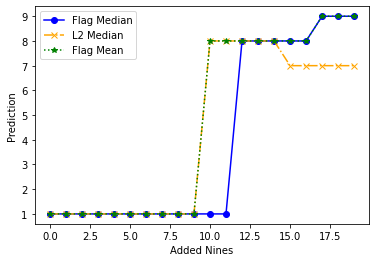

In [7]:

# linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
# markers = ['o', '>', 'x', '*']
# colors = ['blue', 'red', 'orange', 'green']
linestyles = ['solid', 'dashdot', 'dotted']
markers = ['o', 'x', '*']
colors = ['blue', 'orange', 'green']
j=0
ci = 0
# for alg in ['Flag Median', 'Maximally Correlated Flag', 'L2 Median', 'Flag Mean']:
for alg in ['Flag Median', 'L2 Median', 'Flag Mean']:
    small = predictions[predictions['Prototype'] == alg][['Added Nines', 'Prediction']]
    x = []
    for i in range(20):
        temp = np.array(small[small['Added Nines'] == i]['Prediction'])
        x.append(temp)

    plt.plot(np.arange(20), x, label = alg, linestyle = linestyles[j], marker = markers[j], color = colors[j])

    j+=1
plt.legend()
plt.xlabel('Added Nines')
plt.ylabel('Prediction')


## MNIST MDS

In [12]:
def run_embedding_test(k, include_data = True):
    '''
    plots MDS embedding of exemplars and datasets with 20 examples of 7s and 0,1,2,...,19 examples of 6s
    
    Inputs: 
        k (integer) points on Gr(k,n)
    '''
    num_samples1 = 20 #number of samples of the 6 digit
    n_its = 20 #number of iterations for FlagIRLS
    seed = 1 #for initialization
    incr = 1 #samples 5s from 0 to num_samples2 in increments of incr
    # plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS
    digit1 = 6
    digit2 = 7

    if num_samples1 % incr != 0:
        print('incr does not divide num_samples2 evenly!')
        
    
    flagmeans = []
    flag_medians = []
    max_cor_flgs = []
    l2_meds = []
    n2s  = []
    n5s = []

    for num_samples2 in range(0,num_samples1,incr):
        out = run_mnist_test(k,digit1,digit2,num_samples1,num_samples2,n_its,seed)
        flagmeans.append(out[0])
        flag_medians.append(out[1])
        l2_meds.append(out[2])
        n2s.append(num_samples1)
        n5s.append(num_samples2)
        dataset = out[3]
        # max_cor_flgs.append(out[2])
        # l2_meds.append(out[3])
        # n2s.append(num_samples1)
        # n5s.append(num_samples2)
        # dataset = out[4]

    dataset_and_averages = dataset + flag_medians + max_cor_flgs + l2_meds + flagmeans

    n_all_pts = len(dataset_and_averages)

    Distances = np.zeros((n_all_pts, n_all_pts))

    for i in range(n_all_pts):
        for j in range(i+1, n_all_pts):
            sin_sq = k - np.trace(dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])
            if sin_sq < 0:
                sin_sq = 0
            Distances[i,j] = np.sqrt(sin_sq)
            Distances[j,i] = Distances[i,j].copy()

    # for i in range(n_all_pts):
    #     for j in range(i+1, n_all_pts):
    #         if k == 1:
    #             cos = (dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])[0][0]
    #             if cos > 1:
    #                 cos = 1
    #             elif cos < 0:
    #                 cos = 0
    #             Distances[i,j] = np.arccos(np.sqrt(cos))
    #             Distances[j,i] = Distances[i,j].copy()
    #         else:
    #             cos = np.linalg.svd(dataset_and_averages[i].T @ dataset_and_averages[j])[1]
    #             sumcos = np.sum(np.arccos(cos)**2)
    #             if np.isnan(sumcos):
    #                 print(cos)
    #                 sumcos = 0
    #             Distances[i,j] = np.sqrt(sumcos)
    # #             Distances[i,j] = k - np.trace(dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])
    #             Distances[j,i] = Distances[i,j].copy()

    embedding = MDS(dissimilarity = 'precomputed', n_components = 2)
    transformed = embedding.fit_transform(Distances)

    for i in range(0,num_samples2+1,4):
        plt.figure()
        if include_data:
            plt.scatter(transformed[:num_samples1,0], transformed[:num_samples1,1], c = '.2', label = 'Sevens')
            if i > 0:
                plt.scatter(transformed[num_samples1:num_samples1+i,0], transformed[num_samples1:num_samples1+i,1], color = 'purple', marker = 'x', label = 'Sixes')
        plt.plot(transformed[num_samples1+num_samples2:num_samples1+num_samples2+i+1,0], transformed[num_samples1+num_samples2:num_samples1+num_samples2+i+1,1], c = 'blue', fillstyle = 'none', marker = '>', markevery = 4, label = 'Flag Median')
        plt.plot(transformed[num_samples1+(num_samples2+1)*2-1:num_samples1+(num_samples2+1)*2-1+i+1,0], transformed[num_samples1+(num_samples2+1)*2-1:num_samples1+(num_samples2+1)*2-1+i+1,1], c = 'orange', linestyle = 'dashdot', fillstyle = 'none', marker = '>', markevery = 4, label = 'L2 Median')
        plt.plot(transformed[num_samples1+(num_samples2+1)*3-1:num_samples1+(num_samples2+1)*3-1+i+1,0], transformed[num_samples1+(num_samples2+1)*3-1:num_samples1+(num_samples2+1)*3-1+i+1,1], c = 'green', linestyle = 'dotted', fillstyle = 'none', marker = '>', markevery = 4, label = 'Flag Mean')

        # plt.plot(transformed[num_samples1+(num_samples2+1)*2-1:num_samples1+(num_samples2+1)*2-1+i+1,0], transformed[num_samples1+(num_samples2+1)*2-1:num_samples1+(num_samples2+1)*2-1+i+1,1], c = 'red', linestyle = 'dashed', fillstyle = 'none', marker = '>', markevery = 4, label = 'Maximally Correlated Flag')
        # plt.plot(transformed[num_samples1+(num_samples2+1)*3-1:num_samples1+(num_samples2+1)*3-1+i+1,0], transformed[num_samples1+(num_samples2+1)*3-1:num_samples1+(num_samples2+1)*3-1+i+1,1], c = 'orange', linestyle = 'dashdot', fillstyle = 'none', marker = '>', markevery = 4, label = 'L2 Median')
        # plt.plot(transformed[num_samples1+(num_samples2+1)*4-1:num_samples1+(num_samples2+1)*4-1+i+1,0], transformed[num_samples1+(num_samples2+1)*4-1:num_samples1+(num_samples2+1)*4-1+i+1,1], c = 'green', linestyle = 'dotted', fillstyle = 'none', marker = '>', markevery = 4, label = 'Flag Mean')
        if i == 8:
            plt.legend()
            plt.xlabel('MDS 1')
            plt.ylabel('MDS 2')

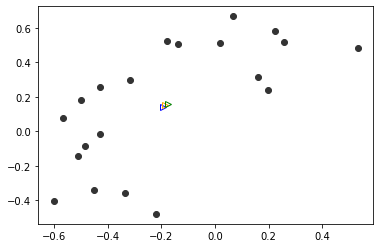

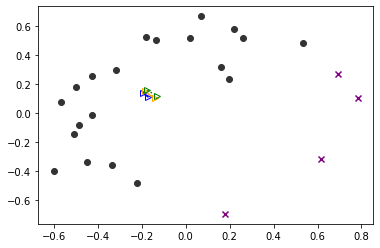

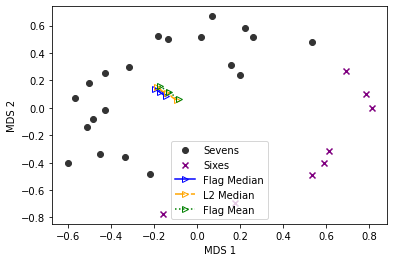

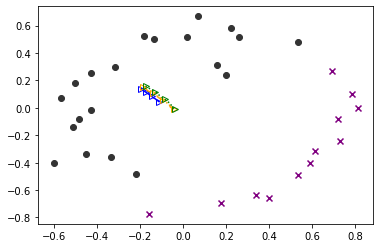

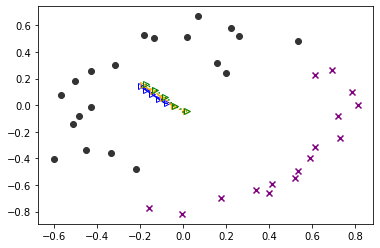

In [13]:
run_embedding_test(1)

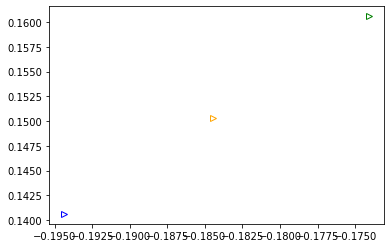

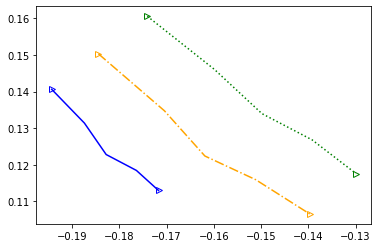

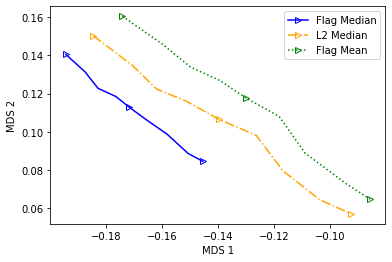

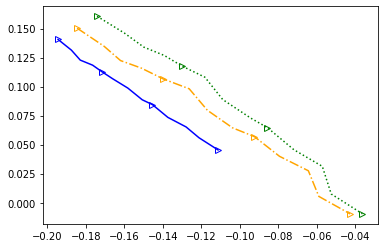

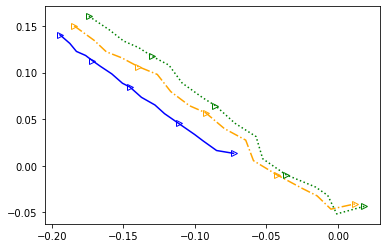

In [14]:
run_embedding_test(1, False) 

## MNIST Dimensions of Prototypes with Outlier Datasets

In [16]:
num_samples1 = 20 #number of samples of the 6 digit
num_samples2 = 8
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 1 #samples 5s from 0 to num_samples2 in increments of incr
plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS
digit1 = 7
digit2 = 6


k=5

if num_samples1 % incr != 0:
    print('incr does not divide num_samples2 evenly!')



out = run_mnist_test(k,digit1, digit2, num_samples1,num_samples2,n_its,seed)
flag_mean = out[0]
flag_median = out[1]
l2_med = out[2]
dataset = out[3]
# max_cor_flg = out[2]
# l2_med = out[3]
# dataset = out[4]


/tmp/ipykernel_119852/2670674176.py:37: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


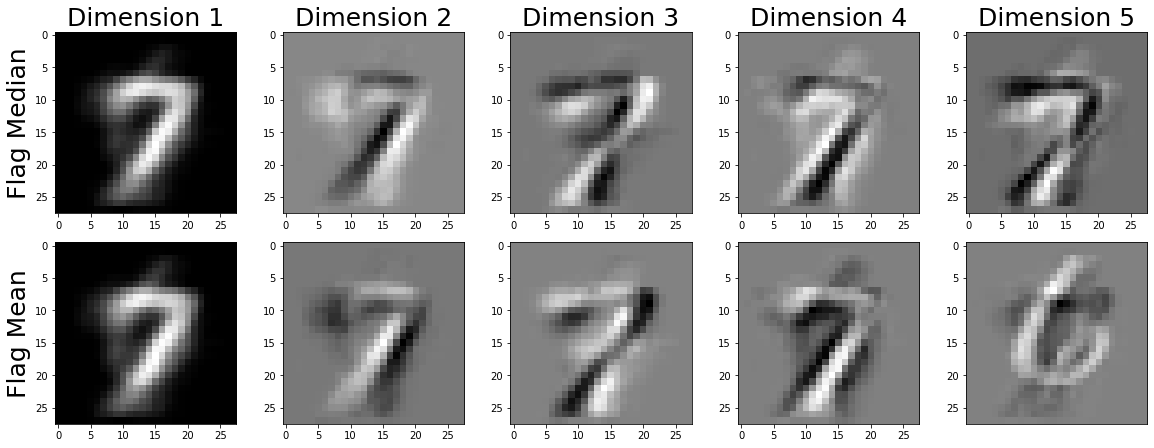

In [22]:
from matplotlib import gridspec
#8 examples of 6s

num_tests = num_samples2//incr
nrow=2
ncol=5

fig, axs = plt.subplots(2, 5, figsize=(16,6), constrained_layout=True)


for ii in range(k):


    axs[0,ii].imshow(flag_median[:,ii].reshape(28,28), cmap = 'gray')

    axs[1,ii].imshow(flag_mean[:,ii].reshape(28,28), cmap = 'gray')




plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelside=False) # labels along the bottom edge are off



plt.tight_layout()
cols = [ 'Dimension '+str(ii+1) for ii in range(k)]
rows = ['Flag Median', 'Flag Mean']

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=25)    


for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size = 25)

    
# fig.tight_layout()
plt.show()

# Minds Eye

In [ ]:
#using dataset from Marrinan et al. 
#see https://www.cs.colostate.edu/~vision/summet/
%run scripts/run_lbg_minds_eye

# UCF YouTube Action

In [ ]:
#generate data on grassmannian
#data downloaded from https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php 
#UCF YouTube Action Dataset
%run scripts/youtube_dataset 

In [ ]:
#run LBG
%run scripts/run_lbg_youtube